# RTL-SDR Ultrasound Test
Copyright (C) 2018 William Meng

This file is part of rtlsdr_ultrasound

rtlsdr_ultrasound is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

rtlsdr_ultrasound is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with rtlsdr_ultrasound.  If not, see <http://www.gnu.org/licenses/>.

-------
William Meng K9TTL  
Aug 18, 2018

In this notebook, I will try to capture and plot some real data from the SimpleRick hardware.
The piezo transducer is placed in a box of water, ~~and is rotated back and forth with a servo motor.~~
For simplicity, in this experiment the piezo will be stationary.
Hopefully we'll see some echoes from the ultrasound waves reflecting off the plastic walls of the box.

Experimental setup:
![plastic box filled with water](DSCN7874.JPG)
![overall setup](DSCN7876.JPG)

What the echoes look like on the oscilloscope:
![echos, stationary](NewFile18.png)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from rtlsdr import *
from scipy.signal import resample
import time
from datetime import datetime
%matplotlib inline

## Configure settings for RTL-SDR

In [13]:
sdr = RtlSdr()

# configure device
sdr.set_direct_sampling(2) # directly sample Q channel
sdr.center_freq = 8e6
sdr.sample_rate = 2.4e6
sdr.gain = 'auto'

center_freq = sdr.center_freq
sample_rate = sdr.sample_rate
print("center freq = {} Hz".format(center_freq))
print("sample rate = {} Hz".format(sample_rate))
print("gain = {}".format(sdr.gain))

center freq = 8000000 Hz
sample rate = 2400000.0 Hz
gain = 0.0


## Acquire data and save to file

In [14]:
%%time
# read samples
samples = sdr.read_samples(256*10000)
sdr.close()

# save samples to disk with timestamp
timestamp = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H:%M:%S')
np.save("rtlsdr_ultrasound_test_{}".format(timestamp), samples)

CPU times: user 580 ms, sys: 181 ms, total: 761 ms
Wall time: 2.14 s


## Load data from file and plot

[-0.00392157+0.00392157j -0.00392157-0.00392157j  0.00392157-0.00392157j
 ..., -0.00392157+0.00392157j  0.00392157-0.00392157j
  0.00392157-0.00392157j]
Found 2560000 samples


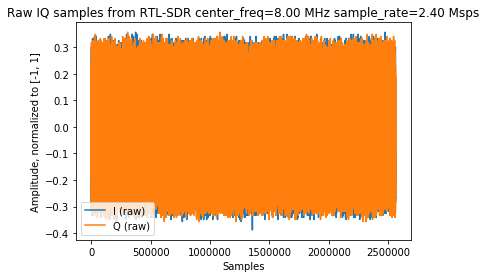

CPU times: user 10.9 s, sys: 840 ms, total: 11.8 s
Wall time: 12.8 s


In [16]:
%%time
samples = np.load("rtlsdr_ultrasound_test_2018-08-18_19:15:04.npy")
print(samples)
print("Found {} samples".format(len(samples)))
I_raw = np.real(samples)
Q_raw = np.imag(samples)
plt.plot(I_raw, label="I (raw)")
plt.plot(Q_raw, label="Q (raw)")
plt.title("Raw IQ samples from RTL-SDR center_freq=%.2f MHz sample_rate=%.2f Msps" % (center_freq/1e6, sample_rate/1e6))
plt.xlabel("Samples")
plt.ylabel("Amplitude, normalized to [-1, 1]")
plt.legend()
plt.show()

## Process signal
### Upsample and generate time base

In [17]:
%%time
upsampling_factor = 10
resampled = resample(samples, len(samples) * upsampling_factor)
fs = sample_rate * upsampling_factor
Ts = 1e6/fs # time per sample after resampling, in microseconds
print("Resampled at:")
print("fs = %.2f Msps" % (fs/1e6))
print("Ts = {} microseconds".format(Ts))
t = np.array([ x * Ts for x in range(len(resampled))]) # time base, in microseconds

Resampled at:
fs = 24.00 Msps
Ts = 0.041666666666666664 microseconds
CPU times: user 7.25 s, sys: 1.85 s, total: 9.1 s
Wall time: 10.8 s


### Plot envelope

In [18]:
%%time
envelope = np.abs(resampled)
t_ms = t/1000
#plt.plot(t_ms, envelope, label="envelope")
#plt.xlabel('t (milliseconds)')
#plt.ylabel('amplitude')
#plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
#          (center_freq/1.0e6, sample_rate/1.0e6))
#plt.legend()
#plt.show()

CPU times: user 356 ms, sys: 269 ms, total: 625 ms
Wall time: 821 ms


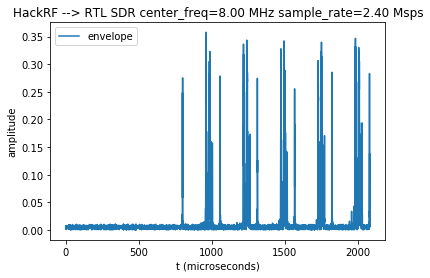

CPU times: user 268 ms, sys: 22.5 ms, total: 291 ms
Wall time: 339 ms


In [20]:
%%time
start = 0
end = 50000
zoomed_envelope = envelope[start:end]
zoomed_t = t[start:end]
plt.plot(zoomed_t, zoomed_envelope, label="envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

For some reason, it seems that the first 750 samples or so are always nearly zero.
Perhaps it takes some time to initialize the ADC hardware in the RTL-SDR,
so the first few packets it sends are zero values.

Also notice that the first peak in the data is NOT a Tx pulse, but rather an echo.
This raises an issue with the triggering algorithm, because the first trigger
will be on a peak other than the Tx pulse, and due to the trigger holdoff,
all subsequent triggers will be "poisoned" by the initial false trigger.

There are a couple ways to workaround this issue:
1. Make sure that the pulser does not start sending Tx pulses until *after* the
RTL-SDR has started sampling data. That guarantees that the first peak seen
by the RTL-SDR will be a Tx pulse.
* Increase the dead time to be large in proportion to the scanline time,
and set the trigger holdoff time to be slightly large than the scanline time
yet much smaller than the overall scanline+dead time.
The long dead time will ensure that the next trigger will be correct, even if the first trigger was wrong.

Option 1 is a good option when serial communication between rtlsdr_ultrasound and SimpleRick firmware is possible.

Option 2 is a good fallback when serial communication is not possible.

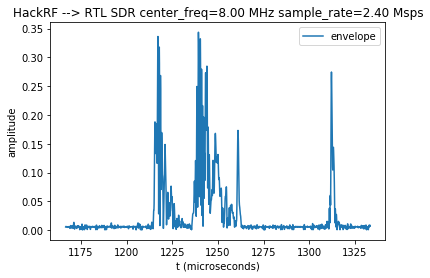

CPU times: user 185 ms, sys: 18 ms, total: 203 ms
Wall time: 206 ms


In [21]:
%%time
start1 = 28000
end1 = 32000
megazoomed_envelope = envelope[start1:end1]
megazoomed_t = t[start1:end1]
plt.plot(megazoomed_t, megazoomed_envelope, label="envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

## Construct image

To construct a 2D ultrasound image, we need to slice the 1D ultrasound signal into individual scan lines.
This can be done by setting a an appropriate threhold amplitude for identifying a trigger pulse,
and the minimum time for a scan line so as to prevent slicing the signal in the middle of a scan line.
This is exactly analogous to the trigger level and trigger holdoff settings on an oscilloscope.

### Set trigger level and holdoff

In [22]:
%%time
max_envelope = np.max(envelope)
print("max(envelope) = {}".format(max_envelope))
trigger_level = 0.7 * max_envelope
print("Trigger level = {}".format(trigger_level))

#plt.plot(t_ms, envelope, label="envelope")
#plt.plot(t_ms, [trigger_level] * len(t_ms), label="trigger level")
#plt.xlabel('t (milliseconds)')
#plt.ylabel('amplitude')
#plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
#          (center_freq/1.0e6, sample_rate/1.0e6))
#plt.legend()
#plt.show()

max(envelope) = 0.4368930655983821
Trigger level = 0.30582514591886745
CPU times: user 55.3 ms, sys: 155 ms, total: 210 ms
Wall time: 217 ms


In [23]:
%%time
trigger_holdoff_us = 130 # trigger holdoff time in microseconds
trigger_holdoff = int(trigger_holdoff_us / Ts) # trigger holdoff in # of samples
print("Trigger holdoff = {} microseconds = {} samples".format(trigger_holdoff_us, trigger_holdoff))

Trigger holdoff = 130 microseconds = 3120 samples
CPU times: user 97 µs, sys: 42 µs, total: 139 µs
Wall time: 145 µs


### Slice into scan lines
Now let's iteratively identify the slicing points, and plot the first few.

In [24]:
%%time
prev_trigger = -trigger_holdoff # allow first trigger to be at 0th sample
slice_indices = list()
for i in range(len(envelope)):
    if i >= prev_trigger + trigger_holdoff:
        if envelope[i] > trigger_level:
            slice_indices.append(i)
            prev_trigger = i

print("Slicing at indices {}".format(slice_indices))
print("Triggered {} times".format(len(slice_indices)))

# Visualize where the slicing happens
slice_lines = np.zeros(len(envelope))
"""
# this is extremely slow, because the numpy array has to be copied in memory for each substitution
for i in range(len(slice_lines)):
    if i in slice_indices:
        slice_lines[i] = -0.1
"""
# faster method:
slice_lines[slice_indices] = -0.1

#plt.plot(t_ms, envelope, label="envelope")
#plt.plot(t_ms, [trigger_level] * len(t_ms), label="trigger level")
#plt.plot(t_ms, slice_lines, label="slice lines")
#plt.xlabel('t (milliseconds)')
#plt.ylabel('amplitude')
#plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
#          (center_freq/1.0e6, sample_rate/1.0e6))
#plt.legend()
#plt.show()

Slicing at indices [23055, 29210, 35349, 41463, 47599, 53774, 59920, 66020, 72156, 78269, 84388, 90504, 96686, 102783, 108887, 114991, 121135, 127236, 133375, 139516, 145608, 151709, 157885, 163954, 170092, 176186, 182324, 188436, 194579, 200668, 206805, 212928, 219052, 225154, 231299, 237401, 243543, 249633, 255775, 261888, 268026, 274118, 280301, 286445, 292599, 298756, 305448, 311062, 317759, 323367, 329480, 335623, 341783, 347920, 354075, 360179, 366277, 372401, 378523, 384662, 390765, 396889, 403005, 409144, 415237, 421379, 427488, 433626, 439735, 445871, 451981, 458122, 464207, 470343, 476463, 482601, 488684, 494821, 500948, 507068, 513169, 519313, 525414, 531553, 537654, 543794, 549912, 556564, 562143, 568312, 574453, 580632, 586765, 592948, 599091, 605249, 611383, 617505, 623633, 629811, 635940, 642062, 648200, 654298, 660954, 666539, 672676, 678813, 684905, 691063, 697155, 703266, 709919, 715516, 721640, 727738, 733876, 739985, 746121, 752229, 758368, 764470, 770614, 776711, 7

Intervals between each trigger are [6155 6139 6114 ..., 5584 6102 6139]
Choosing the minimum, 5454, as the length of each scan line
Not enough samples left for a complete scan line!
Created 4166 scan lines


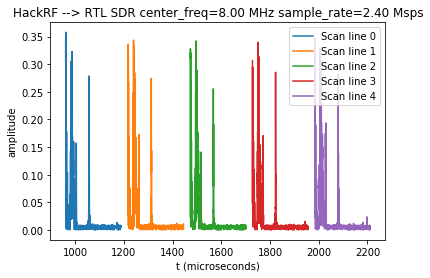

CPU times: user 378 ms, sys: 42.2 ms, total: 420 ms
Wall time: 442 ms


In [25]:
%%time
# slice array and vstack
diffs = np.diff(slice_indices)
min_diff = np.min(diffs)
print("Intervals between each trigger are {}".format(diffs))
print("Choosing the minimum, {}, as the length of each scan line".format(min_diff))

scan_lines = list()
for index in slice_indices:
    if len(envelope) < index + min_diff:
        print("Not enough samples left for a complete scan line!")
        continue
    scan_line = envelope[index:index+min_diff]
    scan_lines.append(scan_line)

print("Created {} scan lines".format(len(scan_lines)))

# Plot first 5 scan lines
for i in range(5):
    index = slice_indices[i]
    plt.plot(t[index:index+min_diff], scan_lines[i], label="Scan line {}".format(i))
 
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
      (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

Notice that it incorrectly triggers on the first echo, rather than the Tx pulse.
Since the piezo is stationary, we can still construct an image, even though it will look like
the top is chopped off and moved to the bottom.

### Stack scan lines into image
Use numpy.vstack(), then (optionally) crop the 2D array to get rid of some blank space.

Image dimensions: (4166, 5454)


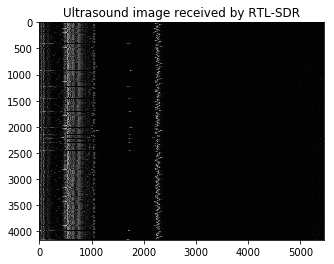

CPU times: user 751 ms, sys: 405 ms, total: 1.16 s
Wall time: 1.22 s


In [27]:
%%time
image = np.vstack(tuple(scan_lines))
print("Image dimensions: {}".format(image.shape))
plt.imshow(image, cmap='gray')
plt.title("Ultrasound image received by RTL-SDR")
plt.show()

### Crop and repeat image for easier viewing

In [28]:
# save 2D array to disk
np.save("rtlsdr_image_2018-08-18_19:15:04.npy", image)

### Polar to Cartesian mapping

See [previous experiment](../20180813/rtlsdr_ultrasound_test.ipynb) for explanation.

In [29]:
image = np.load("rtlsdr_image_2018-08-18_19:15:04.npy")

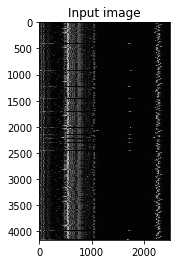

2652.157971683344 rows per radian
theta: [3.9269908169872414, 5.497787143782138] radians
Padding 2083 above and 10415 below


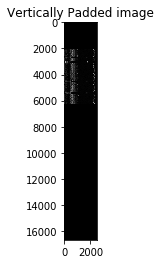

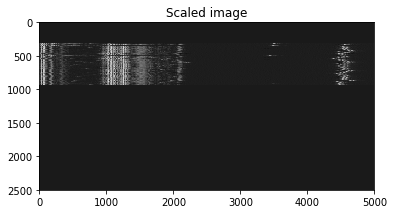

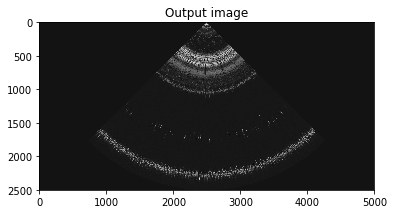

CPU times: user 2.95 s, sys: 1.51 s, total: 4.46 s
Wall time: 4.5 s


In [33]:
%%time
import cv2

maxRadius = 2500
im_in = image[:, :maxRadius] # cut off any data beyond maxRadius
plt.imshow(im_in, cmap='gray')
plt.title("Input image")
plt.show()

angle_range = np.pi/2 # range of angle swept by transducer (radians)
theta_scale_factor = im_in.shape[0] / angle_range # rows per radian
print("{} rows per radian".format(theta_scale_factor))
theta_min = 3/2*np.pi - angle_range/2
theta_max = 3/2*np.pi + angle_range/2
print("theta: [{}, {}] radians".format(theta_min, theta_max))

# pad the image
pad_below = int(theta_min * theta_scale_factor) # how many rows to pad below theta_min
pad_above = int((2*np.pi - theta_max) * theta_scale_factor) # how mahy rows to pad above theta_max
print("Padding {} above and {} below".format(pad_above, pad_below))
im_below = np.zeros((pad_below, maxRadius))
im_above = np.zeros((pad_above, maxRadius))

padded_image = np.vstack((im_above, im_in, im_below))
plt.imshow(padded_image, cmap='gray')
plt.title("Vertically Padded image")
plt.show()

# scale image
scaled_image = cv2.resize(padded_image, (2*maxRadius, maxRadius), interpolation=cv2.INTER_CUBIC)
plt.imshow(scaled_image, cmap='gray')
plt.title("Scaled image")
plt.show()

# transform image
center = (int(scaled_image.shape[1]/2), 0) # (x, y) coordinate from top-left of image
flags = cv2.WARP_INVERSE_MAP
im_out = cv2.linearPolar(scaled_image, center, maxRadius, flags)
plt.imshow(im_out, cmap='gray')
plt.title("Output image")
plt.show()

TODO:
* create mask so the image looks prettier
* horizontally pad on the left according to $r_{min}$

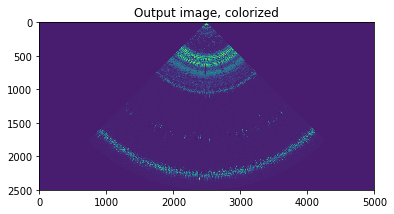

In [34]:
plt.imshow(im_out)
plt.title("Output image, colorized")
plt.show()

In [38]:
# save 2D array of polar2cart image to disk
np.save("rtlsdr_polar2cart_2018-08-18_19:15:04.npy", im_out)
# warning: this file is quite large! ~100MB